## Libraries

In [6]:
import math # for sqrt, log, exponentials
import numpy as np # for vectorization and array
import random # for random simulation
import pandas as pd # for dataframe visualization
import matplotlib.pyplot as plt # for plotting data in a graph
import copy # for making predictions
import warnings # no annoying warnings
warnings.filterwarnings('ignore') # to ignore numpy's warnings

These predictions were wrong because of miscalculated data and other external factors.

## Problem 2: Regression Comparison

### 2) Write a program to take a data set and fit a decision tree to it. For d = 10, generate a plot of the decision tree error on the training and testing data as the depth of the tree you’re fitting increases. What appears to be the optimal depth to grow the tree to to minimize the error? How does the performance of this tree compare to the performance of the constant model?

In [1]:
def generate_data_point(dimensions):
    """
    Purpose:
    Generates a data point of at least 5 dimensions
    and and output value.
    
    Parameters:
    dimensions - an integer greater or equal to 5 and determines 
    the number of features in the datapoint
    
    Returns:
    feature_vector - a list with a length of (dimensions + 1)
    where all elements are features
    
    Y - our desired output based of the five first features (integer)
    """
    
    # defualt generated features
    x1 = np.random.normal(3,1)
    x2 = np.random.normal(-2,1)
    x3 = x2 + x1
    x4 = (x2 + 2) ** 2
    x5 = np.random.choice([1,0], p = [0.80,0.20])
    
    feature_vector = [x1,x2,x3,x4,x5]
    
    # if there are more than 5 dimensions
    if dimensions > 5:
        # we are adding dimensions based on the user's input
        for _ in range(0,dimensions-5):
            feature_vector.append(np.random.normal(0,1))
            
    # getting our desired Y, outout
    Y = (4) - (3*(x1**2)) + (x3) - (0.01 * x4) + (x2*x5) + (np.random.normal(0,0.1))
    
    return feature_vector, Y

def generate_test_train_data_sets(training_data_size = 10000, testing_data = 1000, dimensions = 5):
    """
    Purpose:
    To use the generate_data_point function to generate training
    data and testing_data
    
    Parameters:
    training_data_size - an integer specifying how many training data points
    you would like to generate
    
    dimensions - an integer that specifies number of dimensions or 
    features for each data point
    
    testing_data - an integer telling us how many testing data points
    we would like to generate
    
    Returns:
    x_train - ndarray with shape of (dimensions x number of data points)
    y_train - an ndarray vector with a shape of (1 x number of data points)
    
    x_test - ndarray with shape of (dimensions x number of data points)
    y_test - an ndarray vector with a shape of (1 x number of data points)
    """
    
    # intialize our test and training data
    training_data = []
    test_data = []
    
    # specified dimensions must be at least 5
    if dimensions < 5:
        dimensions = 5
    
    # generating the training data
    for _ in range(0,training_data_size):
        training_data.append(generate_data_point(dimensions))
        
    # generating testing data
    for _ in range(0,testing_data):
        test_data.append(generate_data_point(dimensions))
    
    # putting our generated data into a numpy ndarray
    x_train = np.stack([x[0] for x in training_data])
    y_train = np.stack([x[1] for x in training_data])
    
    x_test = np.stack([x[0] for x in test_data])
    y_test = np.stack([x[1] for x in test_data])
    
    return x_train, y_train, x_test, y_test

def pick_best_feature(x_data,y_data):
    """
    Purpose:
    To pick the most relevant feature in the dataset to
    split on.
    
    Paramters:
    x_data - ndarray of shape (dimensions x number of training samples)
    y_data - ndarray of shape (1 x number of training samples)
    exclude - a list that contains features we do not need to use anymore
    
    Returns:
    best_alpha - a float value that represents
    the smallest overall error based on the given x_data, y_data,
    and decision tree
    """

    # What variable should be decide to split on?
    # separating the features in the x_train array into their own respective arrays
    # we store the i-th feature number and the respective covariance in a dictionary
    # because we are using numpy can calculate the covaraiance of these features without using any for loops

    correlation_dict = dict()
    number_of_features = x_train.shape[1]

    for feature_number in range(0,number_of_features):

        m = x_train.shape[0] # number of training samples
        feature_i = x_train[:, feature_number] # getting a column of the first i-th features

        # calculating needed values
        covariance = np.sum((1/m)*(feature_i * y_train)) - (np.sum((1/m) * feature_i) * np.sum((1/m) * y_train))
        variance_x = np.sum((1/m) * feature_i**2) - np.sum((1/m) * feature_i)**2
        variance_y = np.sum((1/m) * y_train**2) - np.sum((1/m) * y_train)**2

        # putting them together
        correlation = np.abs((covariance/math.sqrt(variance_x*variance_y)))

        # adding to the correlation dictionary to hold our data
        correlation_dict[correlation] = feature_number
        
    # getting most correlated_feature
    most_correlated_feature = correlation_dict[np.max(list(correlation_dict.keys()))]
    
    return most_correlated_feature

def get_best_alpha(x_data,y_data,most_correlated_feature):
    """
    Purpose:
    This function is a greedy type of algorithm. We select the best
    alpha that minimizes our total error across the left and right
    branches of our decision tree. 
    
    Parameters:
    x_data - ndarray of shape (dimensions x number of training samples)
    y_data - ndarray of shape (1 x number of training samples)
    most_correlated_feature - an inetger that represents the most current correlated feature
    
    Returns:
    best_alpha - a float value that represents
    the smallest overall error based on the given x_data, y_data,
    and decision tree
    error_right - a float represetning the error down the right side of the tree
    error_left - a float representing the error down the left side of the tree
    """
    
    # how do we pick an alpha to split on?
    feature_i = x_data[:, most_correlated_feature]

    shifted_left = x_data[:, most_correlated_feature][:-1]
    shifted_right = x_data[:, most_correlated_feature][1:]

    # possible alphas
    mid_points = (shifted_left - shifted_right) / 2 

    alpha_dict = dict() # to hold the respective error and alpha values
    # choosing the alpha that gives us the LEAST 
    for alpha in mid_points:

        y_right = y_data[feature_i < alpha] # right y data
        y_left = y_data[feature_i >= alpha] # left y data

        right_data = feature_i[feature_i < alpha] # right training data
        left_data = feature_i[feature_i >= alpha] # left training data

        m_right = len(right_data) # length of right data
        m_left = len(left_data) # length of left data

        # if we have no right data points
        if m_right != 0:
            error_right = (1/m_right) * np.sum((y_right-np.mean(y_right))**2)
        else:
            error_right = 0 # then there is no right error

        # if we have no left data points
        if m_left != 0:
            error_left = (1/m_left) * np.sum((y_left-np.mean(y_left))**2)
        else:
            error_left = 0 # then there is no left error

        # incase we do not have any data points - unlikely
        if error_right != 0 or error_left != 0:
            
            total_error = ((m_right/(m_right+m_left))*error_right) + ((m_left/(m_right+m_left))*error_left)

            # keeping track of our alphas and our errors
            alpha_dict[total_error] = [alpha,error_right,error_left]
    
    
    # getting the best alpha (based off the smallest error)
    # and the error_right, error_left
    data = alpha_dict[np.min(list(alpha_dict.keys()))]
    
    best_alpha = data[0]
    error_right = data[1]
    error_left = data[2]
    
    # adding to training error
    training_error.append(error_right + error_left)
    
    return best_alpha, error_right, error_left

def split_data(x_data,y_data,most_correlated_feature,alpha):
    """
    Purpose: To split our x_data and y_data into two separate
    parts based on the given alpha
    
    Parameters:
    x_data - ndarray of shape (dimensions x number of training samples)
    y_data - ndarray of shape (1 x number of training samples)
    most_correlated_feature - an inetger that represents the most current correlated feature
    alpha - a float value used to split our data into two separate parts
    
    Returns:
    x_data_right = ndarray of shape (dimensions x number of training samples)
    x_data_left = ndarray of shape (dimensions x number of training samples)
    y_data_right - ndarray of shape (1 x number of training samples)
    y_data_left - ndarray of shape (1 x number of training samples)
    """
    
    # selecting the feature based on most_correlated_feature
    feature_i = x_data[:, most_correlated_feature]
    
    # splitting our data
    x_data_right = x_data[feature_i < alpha]
    x_data_left = x_data[feature_i >= alpha]
    
    y_data_right = y_data[feature_i < alpha]
    y_data_left = y_data[feature_i >= alpha]
    
    # returning all the values
    return x_data_right, x_data_left, y_data_right, y_data_left
    
def build_decision_tree(branch,x_data,y_data,min_sample_size, max_depth = 99999999):
    """
    Purpose: To fit our randomly generated data to a decision tree.
    
    Paramters:
    branch - a dictionary containing an alpha, feature, and other branches (R and L)
    x_data - the data from the split data, ndarray of shape (dimensions x number of training samples)
    y_data - the data from the split data, ndarray of shape (dimensions x number of training samples)
    min_sample_size - an integer telling us when to return the average of all the y values in the branch
    max_depth - an integer specifying the most the decision tree can grow (by default it is set to a large number)
    
    Returns:
    None
    """
    
    # finding the feature and alpha to split on
    feature = pick_best_feature(x_data,y_data)
    
    alpha, error_right, error_left = get_best_alpha(x_data,y_data,feature)

    # splitting on the most relavent features with alpha
    x_data_right, x_data_left, y_data_right, y_data_left = split_data(x_data,y_data,feature,alpha)

    # keeping track of data throughout the tree
    branch["alpha"] = alpha
    branch["feature"] = feature
    
    # getting depths
    current_depth = len(training_error)

    #####
    # The if statements are mirroed for splitting on the right
    # and left sides of the decision tree. I made the tree (or graph) 
    # with dictionaries of dictionaries
    #####
    
    # ending the branch
    if len(y_data_left) <= min_sample_size or x_data.shape[1] == 1 or current_depth >= max_depth:
        branch['L']['guess'] = np.mean(y_data_left)
        
    if branch['L']['guess'] == None:
        if len(y_data_right) == 0:
            x_data_left = np.delete(x_data_left,0,1)
        branch["L"] = {"alpha":None, "feature":None,"R":{"x_data":None,"y_data":None,"guess":None},"L":{"x_data":None,"y_data":None,"guess":None}}
        # add data to the branch
        branch["L"]["x_data"] = x_data_left
        branch["L"]["y_data"] = y_data_left
        # expand the branch
        build_decision_tree(branch["L"],x_data_left,y_data_left,min_sample_size,max_depth)
        
        
    # ending the branch
    if len(y_data_right) <= min_sample_size or x_data.shape[1] == 1 or current_depth >= max_depth:
        branch['R']['guess'] = np.mean(y_data_right)
        
    if branch['R']['guess'] == None:
        if len(y_data_left) == 0:
            x_data_right = np.delete(x_data_right,0,1)
        # build a new branch
        branch["R"] = {"alpha":None, "feature":None,"R":{"x_data":None,"y_data":None,"guess":None},"L":{"x_data":None,"y_data":None,"guess":None}}
        # add data to the branch
        branch["R"]["x_data"] = x_data_right
        branch["R"]["y_data"] = y_data_right
        # expand the branch
        build_decision_tree(branch["R"],x_data_right,y_data_right,min_sample_size,max_depth)

def make_prediction(point):
    
    """
    Makes a prediction given the fitted decision
    tree with the current dataset
    """
    branch = copy.deepcopy(decision_tree)
    while True:
        if len(branch.keys()) == 3:
            guess = branch['guess']
            return guess

        alpha = branch['alpha']
        feature = branch['feature']

        # going down the tree
        if point[feature] < alpha:
            branch = branch["R"]
        elif point[feature] >= alpha:
            branch = branch["L"]
            
def evaluate_performance():
    
    global x_test, y_test
    
    """
    Purpose:
    To evaluate the model's performance throughout
    training and testing
    
    Paramters: None
    
    Returns: 
    model_error - a float that represents the model's error throughout training or testing
    graph_error - a list that holds values of the individual errors/predictions
    """
    # evaluating the decision tree's performance
    predictions = []
    for test_point in x_test:
        predictions.append(make_prediction(test_point))
    predictions = np.array(predictions)
    
    # calculating percent based on the percent error of each data point compared with our predictions
    testing_error = 100*np.abs((y_test - predictions) / predictions)
    model_error = round(np.mean(testing_error),2)
    
    # graph error
    graph_error = [np.mean(testing_error[:index]) for index in range(1,len(testing_error))]
    
    return model_error, graph_error

### Using the above functions to generate and fit a decision tree with the code below

In [4]:
def run_experiment(dimensions,min_sample_size,max_depth, show = False, prob2point3 = False):
    """
    Purpose: To use all the above functions in a combined experiment.
    
    Paramters:
    dimensions - an integer specifying the dimensions of the randomly generated data
    min_sample_size - an integer that gives us a min sample size to return the average y-values in the tree
    max_depth - the max depth you want the decision tree going to
    show - a boolean value that shows the summary of the experiment
    prob2point3 - a boolean that records data for the problem 2.3 graph
    
    Returns:
    None - OR metrics if prob2point3 = true
    """
    
    global training_error
    global decision_tree
    global x_train, y_train, x_test, y_test
    global total_model_accuracy
    
    # randomly generating data for d = 10
    x_train, y_train, x_test, y_test = generate_test_train_data_sets(dimensions = 10)

    # intialize out test/train sets to display
    training_error = []
    testing_error = []

    # intializing our decision tree with the first two branches
    decision_tree = {"alpha":None, "feature":None,
                     "R":{"x_data":None,"y_data":None,"guess":None},
                     "L":{"x_data":None,"y_data":None,"guess":None}}

    # fit the decision tree from our data
    build_decision_tree(decision_tree,x_train,y_train, min_sample_size, max_depth)

    # getting the testing error
    model_error, testing_error = evaluate_performance()

    # constant model - our prediction are just the average y-value
    constant_model_accuracy = 100 - round(np.mean(100*np.abs((y_test - np.mean(y_test)) / np.mean(y_test))),2)

    # getting the accuracy
    model_accuracy = 100 - model_error

    if show:
        # displaying max depth and min sample
        print("Min Sample size = " + str(min_sample_size) + ", Max Depth = " + str(max_depth))

        # training error plot
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        ax.plot(training_error)
        ax.set_title("Training Error")
        ax.set_ylabel("Error")
        ax.set_xlabel("Iteration")
        # plt.show()

        # testing error plot
        ax2 = fig.add_axes([1.2,0,1,1])
        ax2.plot(testing_error)
        ax2.set_title("Testing Error")
        ax2.set_ylabel("Error")
        ax2.set_xlabel("Iteration")
        plt.show()

        print("Model Accuracy: " + str(model_accuracy) + "%")
        print("Constant Model Accuracy: " + str(constant_model_accuracy) + "%")
        print("Percent Improvement from the Constant Model: " + str(round((100*(model_accuracy-constant_model_accuracy)/constant_model_accuracy),2)) + "%")
        
    if prob2point3:
        return [min_sample_size,max_depth,model_accuracy,constant_model_accuracy]

We know as we train our model our training error should eventually decrease.
<br>However, too much training and the model starts to overfit or 'forget' previous crucial information.
<br>This means that our training error should decrease and then start to increase from that point.
<br>On the otherhand, our testing error should converge to a minimum.
<br>Let's plot the training/testing error below.

Min Sample size = 75, Max Depth = 25


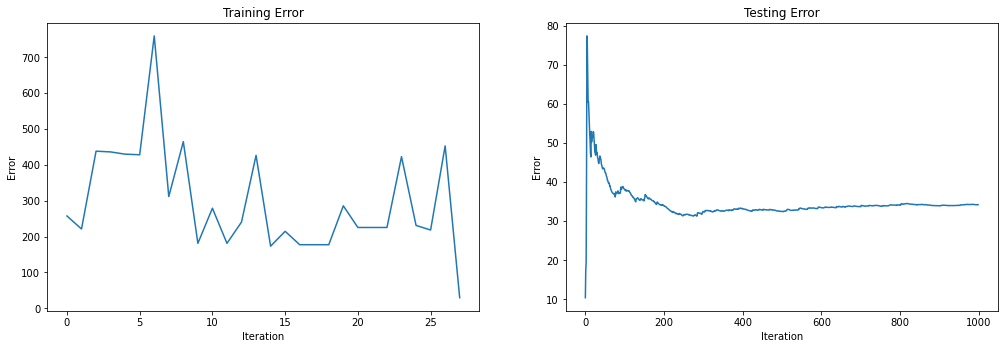

Model Accuracy: 65.81%
Constant Model Accuracy: 48.82%
Percent Improvement from the Constant Model: 34.8%


In [7]:
run_experiment(dimensions = 10, min_sample_size = 75, max_depth = 25, show = True)

We can see that the optimal depth for a sample size of 75, is around 25 by looking at the graph on the left.
<br>Our Model and constant model differ from a ```34.80%``` improvement, which means our model is doing something useful!

### 3) Repeat the experiment, but instead of truncating the tree by depth, truncate by sample size (i.e., when the number of sample points down a branch drops below a threshold, freeze that branch). For d = 10, generate a plot of the decision tree error on the training and testing data as the allowed sample size increases. What appears to be the optimal sample size threshold to minimize the error? How does the performance of this tree compare to the performance of the constant model?

Now, let's assume we have a fixed max tree depth of 25. 

The optimal sample size appears to be most values less than 5000.
<br>The performance of these trees compared to the constant models are almost always better.

In [9]:
total_model_metrics = []
# increasing by a sample size of 25 every time
for new_sample_size in list(range(25,5025,25)):
    metrics = run_experiment(dimensions = 10, min_sample_size = new_sample_size, max_depth = 25, prob2point3 = True)
    total_model_metrics.append(metrics)

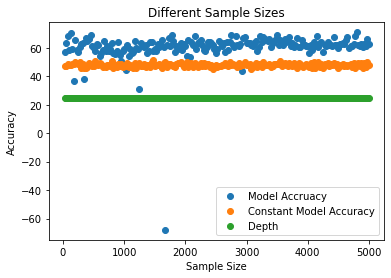

In [11]:
# extracting values from this experiment
samples = [x[0] for x in total_model_metrics]
depths = [x[1] for x in total_model_metrics]
model_accuracy = [x[2] for x in total_model_metrics]
constant_model_accuracy = [x[3] for x in total_model_metrics]

# displaying our gathered data
plt.title("Different Sample Sizes")
plt.ylabel("Accuracy")
plt.xlabel("Sample Size")
plt.scatter(samples,model_accuracy,label = "Model Accruacy")
plt.scatter(samples,constant_model_accuracy, label = "Constant Model Accuracy")
plt.scatter(samples,depths, label = "Depth")
plt.legend()
plt.show()

### 4) Which is better for minimizing error? Truncating by depth or truncating by sample size?

For minimizing error it seems truncating by depth is better.
<br>This is because the depth of the tree controls most of the complexity, and can influence drastic changes in the model's performance.
<br>Too many branches (depth) and we overfit our data, too little and we do our decision tree is not complex enough to model the data.
<br>Truncating by the sample size can only minimize the error up to the data points within that branch of the tree.
<br>This has less of any impact on the model's performance compared to truncating by the depth.

### 5) Consider repeating this experiment but now with d = 50. Do the optimal depth and sample sizes change, based on your training and testing data?

Repeating the experiment for d = 50 below:

Min Sample size = 75, Max Depth = 25


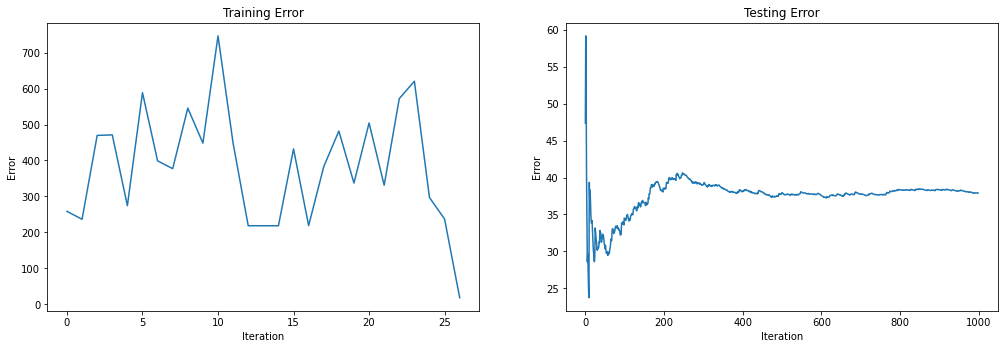

Model Accuracy: 62.08%
Constant Model Accuracy: 46.42%
Percent Improvement from the Constant Model: 33.74%


In [13]:
run_experiment(dimensions = 50, min_sample_size = 75, max_depth = 25, show = True)

The above output is extremely similar to d = 10. 
<br>This is because each of the additional features are not very correlated with our output (y-data).
<br>The way the decision tree is fitted to the data is based on the most correlated feature.
<br>Because each dimension greater than 5 is not correlated much, its affects on the model's performance is very small. 
<br><br>We can see this by correlating the variables, and displaying them below:

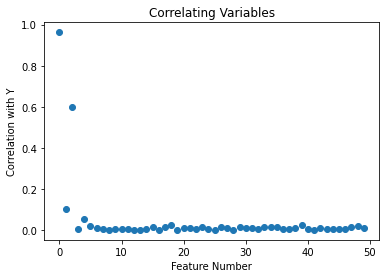

In [14]:
# randomly generating data for d = 50
x_train, y_train, x_test, y_test = generate_test_train_data_sets(dimensions = 50)

# the code below generates a correlation dictionary for the high dimensional data
correlation_dict = dict()
number_of_features = x_train.shape[1]

for feature_number in range(0,number_of_features):

    m = x_train.shape[0] # number of training samples
    feature_i = x_train[:, feature_number] # getting a column of the first i-th features

    # calculating needed values
    covariance = np.sum((1/m)*(feature_i * y_train)) - (np.sum((1/m) * feature_i) * np.sum((1/m) * y_train))
    variance_x = np.sum((1/m) * feature_i**2) - np.sum((1/m) * feature_i)**2
    variance_y = np.sum((1/m) * y_train**2) - np.sum((1/m) * y_train)**2

    # putting them together
    correlation = np.abs((covariance/math.sqrt(variance_x*variance_y)))

    # adding to the correlation dictionary to hold our data
    correlation_dict[correlation] = feature_number
    
plt.title("Correlating Variables")
plt.xlabel("Feature Number")
plt.ylabel("Correlation with Y")
plt.scatter(list(correlation_dict.values()),list(correlation_dict.keys()))
plt.show()

The graph above shows us that every one of these features after the first few are random!
<br>They are not correlated with our data at all! They are just there to try and confuse our decision tree.

### 6) Consider repeating the above experiments for different values of d. Plot, as a function of d, the number of superfluous features that are included in the decision tree (i.e., the number of variables $X_6, . . . , X_d$ that are included in the decision tree). Which approach is better for excluding independent features?

Below are multiple graphs representing the correlation between important and superfluous features.

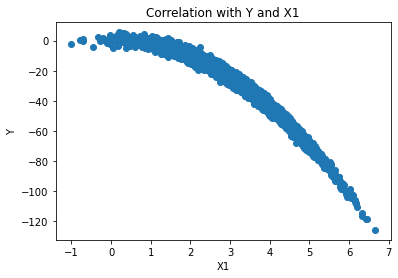

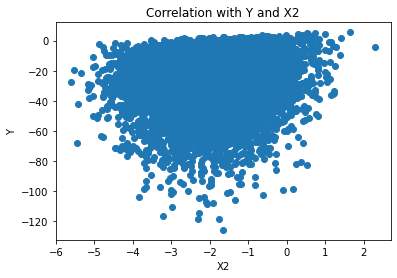

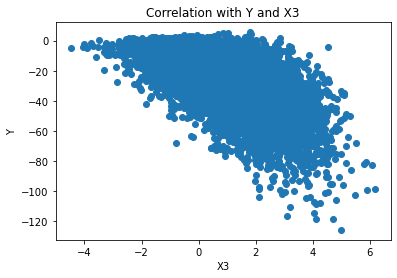

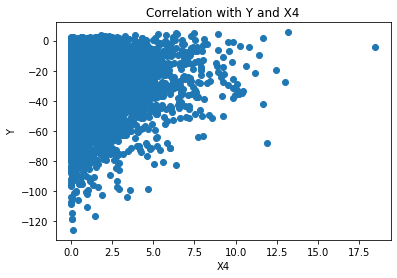

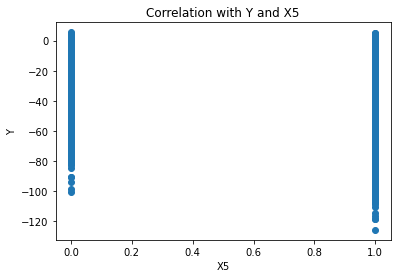

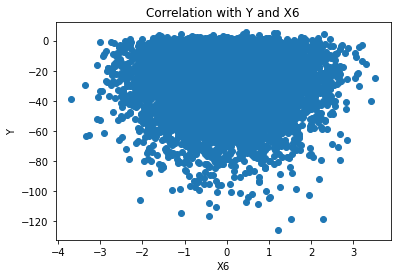

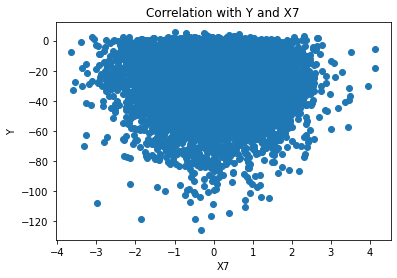

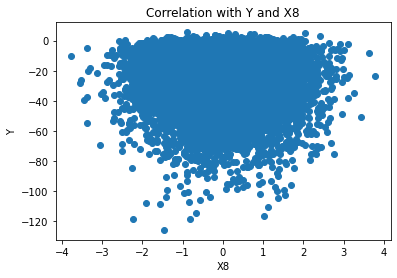

In [15]:
# randomly generating data for d = 50
x_train, y_train, x_test, y_test = generate_test_train_data_sets(dimensions = 50)

# showing the correlation between different features
for feature in range(0,x_train.shape[1]):
    data_to_graph = x_train[:, feature]
    # training error plot
    plt.scatter(data_to_graph,y_train)
    plt.title("Correlation with Y and X" + str(feature + 1))
    plt.xlabel("X" + str(feature + 1))
    plt.ylabel("Y")
    plt.show()
    
    # do not want to show all 50 - clutters the screen
    if feature > 6:
        break


The important features are the first 5 that are somewhat correlated with Y.
<br>All other features after the 5th, and they all have similar correlations with Y. 
<br>They are random as we can see from the graphs above.

### 7) Write a program to take a data set and fit a linear model to it. For d = 10, give the coefficients for your fitted model. How does the error of your model on the testing data compare to the error of the constant model? Is overfitting an issue here?

To fit this to a linear model I will use the following formula below:
$$\underline{W}* = [X^TX]^{-1}X^{T}\underline{Y}$$

In [16]:
x_train, y_train, x_test, y_test = generate_test_train_data_sets(dimensions = 10)

X = x_train
Y = y_train

# w_star contains the 10 coefficients for our model
w_star = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),Y)

for num in range(1,len(w_star) + 1):
    print(str(num) + ". " + "Coefficient: " + str(w_star[num - 1]))

1. Coefficient: -2.350395475952361
2. Coefficient: 9.700858577476543
3. Coefficient: -9.576987786730724
4. Coefficient: 0.7910295183733672
5. Coefficient: 6.149086253400519
6. Coefficient: 0.02052286303712557
7. Coefficient: -0.013018517723371485
8. Coefficient: -0.02895314809229367
9. Coefficient: 0.053421766159271245
10. Coefficient: -0.0427162823416489


These coefficients make a lot of sense
<br>The 'higher weights' correspond with the most correlated variables in the dataset.
<br>Note, again how after the 5th variable the magnitude of weights are very small because those variables are not correlated with Y that well.

The testing error of this linear model is 73046.90477598856
The testing error of the constant model is 322957.07345111045


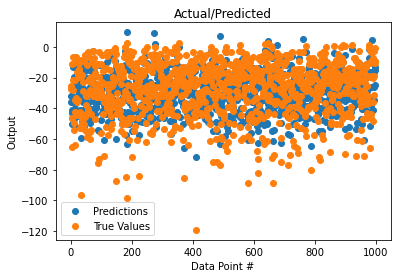

In [17]:
# testing with our generated test data - gathering our predictions
predictions = []
for test_point in x_test:
    predictions.append(np.dot(w_star,test_point)) # dot product
predictions = np.array(predictions)

# error of our model on the testing data
testing_error = np.sum(((y_test - predictions)**2))

print("The testing error of this linear model is " + str(testing_error))
# visuals
plt.title("Actual/Predicted")
plt.xlabel("Data Point #")
plt.ylabel("Output")
plt.scatter(x = range(0,len(predictions)),y = predictions, label = "Predictions")
plt.scatter(x = range(0,len(predictions)),y = y_test, label = "True Values")
plt.legend()

# calculating the constant model 
testing_error_constant = np.sum(((y_test - np.mean(y_test))**2))
print("The testing error of the constant model is " + str(testing_error_constant))

plt.show()

The error of this model is better than the error of the constant model.
<br>This is not surprising.
<br>The linear model above is great for modeling linear data, but the data we are working with is not entirely linear.
<br>This model is also subject to overfitting.
<br>The blue dots represent the predictions and the orange dots represent the true values.
<br>You can see that the blue dots are very crowded in one area and fail to generalize to the outter orange dots.
<br>You can estimate that 99% of the blue dots are between values of -60 and 20. There are almost none outside this range.
<br>So, this model above is subject to a very small amount of overfitting.

### 8) Consider the following scheme to try to eliminate superfluous features: when you fit a model, look at the weight on each feature. If for feature $i, |w_i | ≤ \epsilon$, eliminate that feature from consideration. Whatever features remain, re-fit a linear model on those features. For d = 50, plot the number of superfluous features that make it into the final model as a function of $\epsilon$, and plot the error on the testing data for the final model as a function of $\epsilon$. Is this a good strategy?

In [18]:
x_train, y_train, x_test, y_test = generate_test_train_data_sets(dimensions = 50)

X = x_train
Y = y_train

# w_star contains the 50 coefficients for our model
w_star = np.dot(np.dot(np.linalg.inv(np.dot(X.T,X)),X.T),Y)

# showing some of the coefficients
for num in range(1,len(w_star) + 1):
    print(str(num) + ". " + "Coefficient: " + str(w_star[num - 1]))
    # dont want to display all 50
    if num > 13:
        break

1. Coefficient: -18.3087261224817
2. Coefficient: 10.259970530498418
3. Coefficient: 8.084781356557608
4. Coefficient: 0.7504351126802342
5. Coefficient: 6.041277722157055
6. Coefficient: -0.1424270396097792
7. Coefficient: 0.10751401306014619
8. Coefficient: 0.14217689862041497
9. Coefficient: 0.007556563028365
10. Coefficient: 0.1515416367220052
11. Coefficient: 0.11359822115960258
12. Coefficient: -0.08029906621572641
13. Coefficient: -0.03574949499255402
14. Coefficient: -0.19547280650127669


In [19]:
# let's remove the superfluous weights from the model
# the mean the magnitude of all the elements
epsilon = np.mean(np.abs(w_star))

# so we can iterate through it
w_star = list(w_star)

for coefficient in enumerate(w_star):
    if np.abs(coefficient[1]) < epsilon:
        w_star[coefficient[0]] = 0 # set the coefficient to zero (get rid of it)
        
print(f"Epsilon = {epsilon}\n")
# showing some of the coefficients
for num in range(1,len(w_star) + 1):
    print(str(num) + ". " + "Coefficient: " + str(w_star[num - 1]))
    # dont want to display all 50
    if num > 6:
        break

Epsilon = 0.9311914734043915

1. Coefficient: -18.3087261224817
2. Coefficient: 10.259970530498418
3. Coefficient: 8.084781356557608
4. Coefficient: 0
5. Coefficient: 6.041277722157055
6. Coefficient: 0
7. Coefficient: 0


No superfluous features made it into the model. All features are feature number 5 were eliminated.

The testing error of this linear model is 1643050.564617624
The testing error of the constant model is 307112.0608910032


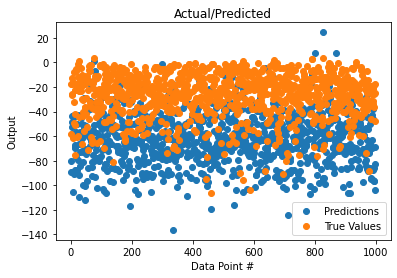

In [20]:
# testing with our generated test data - gathering our predictions
predictions = []
for test_point in x_test:
    predictions.append(np.dot(w_star,test_point)) # dot product
predictions = np.array(predictions)

# error of our model on the testing data
testing_error = np.sum(((y_test - predictions)**2))

print("The testing error of this linear model is " + str(testing_error))
# visuals
plt.title("Actual/Predicted")
plt.xlabel("Data Point #")
plt.ylabel("Output")
plt.scatter(x = range(0,len(predictions)),y = predictions, label = "Predictions")
plt.scatter(x = range(0,len(predictions)),y = y_test, label = "True Values")
plt.legend()

# calculating the constant model 
testing_error_constant = np.sum(((y_test - np.mean(y_test))**2))
print("The testing error of the constant model is " + str(testing_error_constant))

plt.show()

This is a good strategy as long as you know how to properly select $\epsilon$ to remove superfluous features.
<br>It removes features that have little to no impact on your predictions.
<br>But now we have another problem...

### 9) Which model is superior here? Why?

The first model is superior.
<br>It turns out these extra 'random' features actually help with our original overfitting problem.
<br>Removing these extra features results in underfitting and actually makes our error greater than the previous model.
<br>In this case, it would be worth our time to look into selecting a different $\epsilon$ or setting a threshold to how many features you can remove.
<br>In the graph above you can see how the orange (predicted) covers less of the blue (true values).